# Project 2 : Ames Housing Data and Kaggle Challenge

## Data Preprocessing and Feature Engineering

In [1]:
## Importing libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error
sns.set_style('whitegrid')
import patsy
import statsmodels.api as sm
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### 1. Load the Clean Traindata set

In [2]:
#read the csv file from relative path
traindata=pd.read_csv(r'C:\Users\User\materials\project_2\datasets\traindata_clean.csv')

#### 2. Split the columns to numberic and catagorical columns

In [3]:
#get an list contain all numberic columns
train_numberic_column=traindata._get_numeric_data().columns
#get an list of all columns name
train_columns=traindata.columns

In [4]:
#write an loop to get a list of catergory columns
train_category_columns=[]
for x in train_columns:
    if x not in train_numberic_column:
        train_category_columns.append(x)

#### 3. One-hot encoded categorical variables

In [5]:
#convert the categorical variable to one-hot encoded
traindata=traindata[train_numberic_column].join(pd.get_dummies(traindata[train_category_columns]),how="outer")

#### 4. Investigate or manufacture features with linear relationships to the target variable

#### I will drop the features that have a weak relationship with our target variable, "SalePrice." Variables have smaller |Correlation coefficients| value tend to have a weaker connection with "SalePrice." Below Codes help to automatically scan all the variables have |Correlation coefficients| with "SalePrice" less than a fixed value. Initially, I set this fixed value as +/-0.5, later I will change this value to see how it will affect the model. I will drop all those variables with a weak relationship with "SalePrice."

In [6]:
#creat a drop column list
drop_columns=[]
#write for loop to append the columns name to the list if its correlation again "Saleprice" more than+/-0.3
for i in range(len(traindata.corr().loc["SalePrice"])):
    if 0<traindata.corr().loc["SalePrice"][i]<0.5 or -0.5<traindata.corr().loc["SalePrice"][i]<0:
       drop_columns.append(traindata.columns[i])

In [7]:
#drop the columns with low correlation against target
traindata=traindata.drop(columns=drop_columns)

####  Some features that contain multicollinear, , when multicollinearity exists, indicate that changes in one variable are associated with the changes in another variable. The stronger the correlation, the more difficult it is to change one variable without changing another. It becomes difficult for the model to estimate the relationship between each independent variable and the dependent variable independently because the independent variables tend to change. Hence, I plot the correlation heatmap to determine which variables are exiting the multicollinear in our data.

Text(196.0, 0.5, 'Columns')

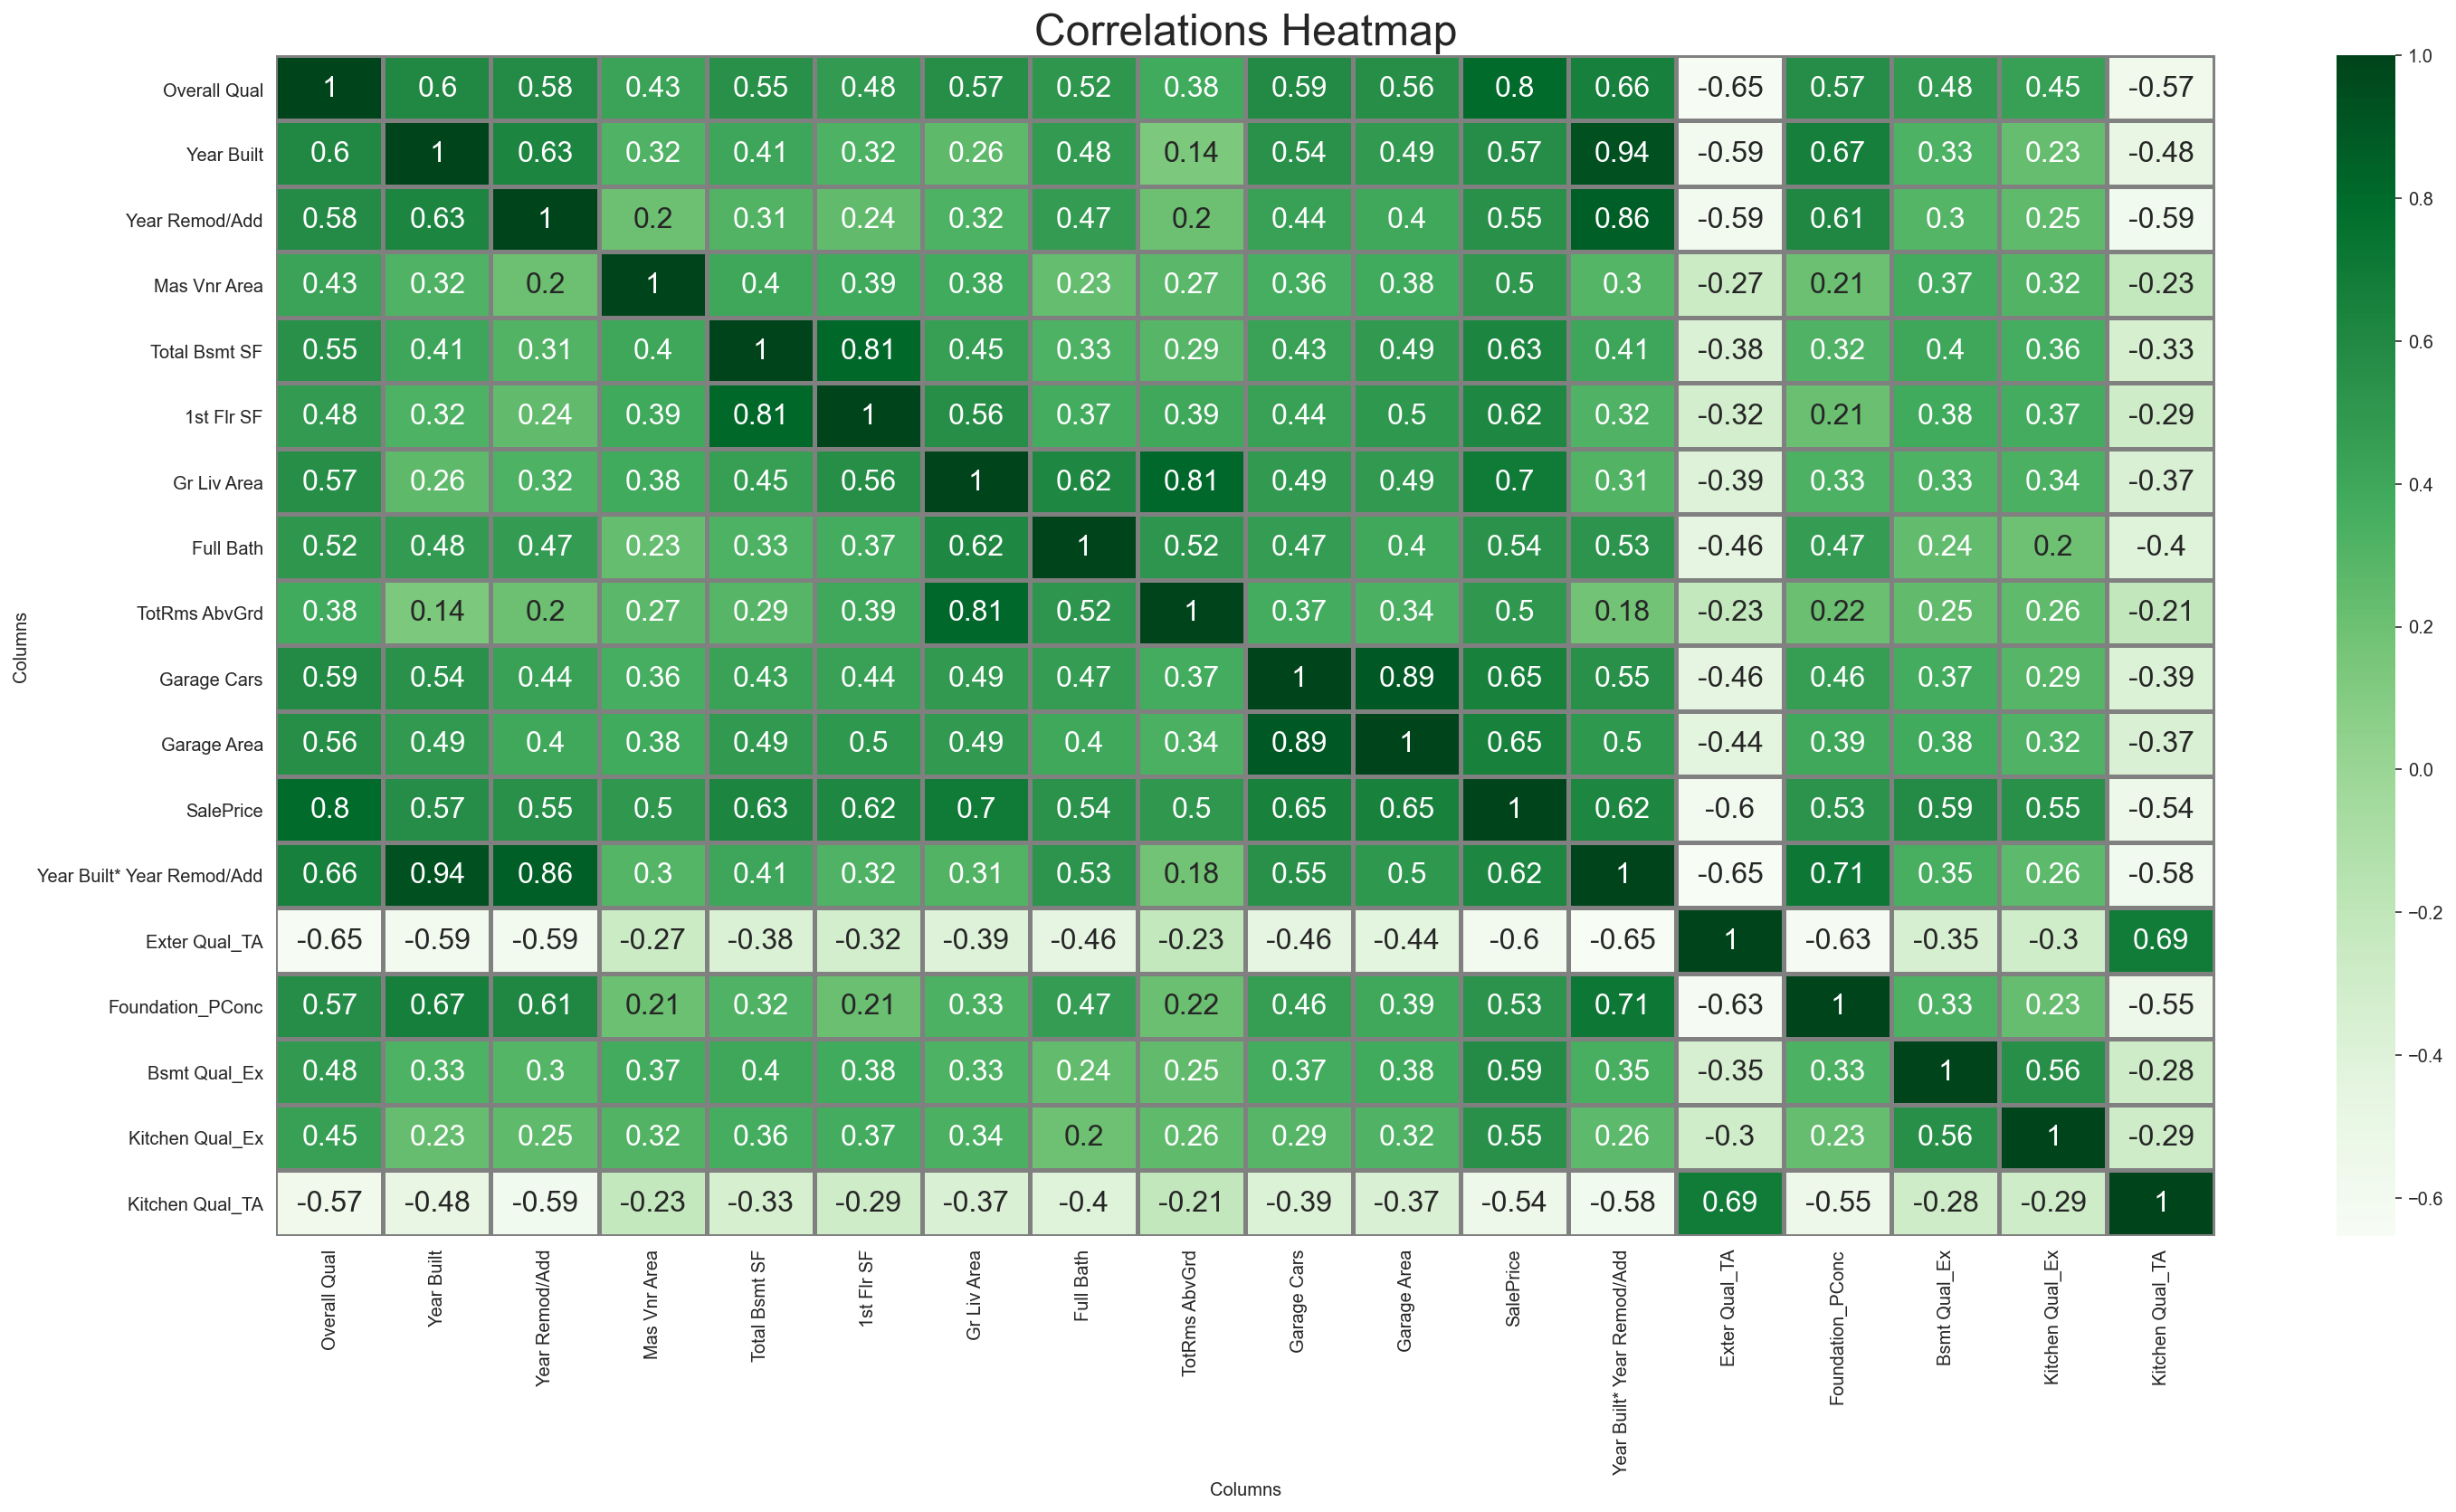

In [8]:
#set the figsize
plt.figure(figsize=(24, 12))
#unpack this tuple into the variables
ax = plt.axes()
#plot the heatmap
sns.heatmap(traindata.corr(),cmap="Greens",annot=True, annot_kws={"size": 16},linewidths=2, linecolor='Grey'); 
#set title
ax.set_title('Correlations Heatmap', fontsize=24)
#set xlabel
ax.set_xlabel('Columns')
#set ylabel
ax.set_ylabel('Columns')

#### Manual drop some features that contain multi-collinear to reduce the noise level

In [9]:
#drop the columns with low correlation against target
traindata=traindata.drop(columns=["Garage Cars","Exter Qual_TA",\
                                  "Kitchen Qual_TA","1st Flr SF","TotRms AbvGrd"])

#### Manual combine some features that contain multi-collinear to reduce the noise level

In [10]:
#combine the columns with collinear relationship
traindata["Bsmt Qual_Ex*Kitchen Qual_Ex"]=traindata["Bsmt Qual_Ex"]*traindata["Kitchen Qual_Ex"]

In [11]:
traindata.columns

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'Total Bsmt SF', 'Gr Liv Area', 'Full Bath', 'Garage Area', 'SalePrice',
       'Year Built* Year Remod/Add', 'Foundation_PConc', 'Bsmt Qual_Ex',
       'Kitchen Qual_Ex', 'Bsmt Qual_Ex*Kitchen Qual_Ex'],
      dtype='object')

#### Statistic Inference
####  I feed all the possible features to statsmodel to check the model's performance, and then remove the worst performing features one by one. The performance metric used here to evaluate feature performance is pvalue. Null hypothesis: no relationship with target variable; alternative hypothesis: relationship existing with the target variable. If pvalue is less than 0.05, the null hypothesis will be rejected. So I remove the features with pvalue more than 0.05

In [12]:
# optionally, you can chain "fit()" to the model object
Xm =traindata[['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',\
       'Total Bsmt SF', 'Gr Liv Area', 'Full Bath', 'Garage Area', 'SalePrice',\
       'Year Built* Year Remod/Add', 'Foundation_PConc', 'Bsmt Qual_Ex',\
       'Kitchen Qual_Ex', 'Bsmt Qual_Ex*Kitchen Qual_Ex']]

#add a constant 
Xm = sm.add_constant(Xm)
#fit the model
model = sm.OLS(traindata["SalePrice"], Xm)
model = model.fit()
#print the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.829e+28
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:59:32   Log-Likelihood:                 35583.
No. Observations:                2051   AIC:                        -7.114e+04
Df Residuals:                    2036   BIC:                        -7.105e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -6.147e-08   1.36e-06     -0.045      0.964   -2.72e-06     2.6e-06
Overall Qual                 -6.793e-12      2e-10     -0.034      0.973   -3.99e-10    3.86e-10
Year Built                    3.365e-11   6.97e-10      0.048      0.961   -1.33e-09     1.4e-09
Year Remod/Add                2.569e-11   6.83e-10      0.038      0.970   -1.31e-09    1.37e-09
Mas Vnr Area                 -5.329e-14   1.08e-12     -0.049      0.961   -2.17e-12    2.07e-12
Total Bsmt SF                 -8.66e-15   4.61e-13     -0.019      0.985   -9.13e-13    8.96e-13
Gr Liv Area                  -4.619e-14    5.3e-13     -0.087      0.931   -1.09e-12    9.93e-13
Full Bath                     1.864e-11   4.14e-10      0.045      0.964   -7.93e-10     8.3e-10
Garage Area                  -7.105e-15   9.87e-13     -0.007      0.994   -1.94e-12    1.93e-12
SalePrice                        1.0000   4.78e-15   2.09e+14      0.000       1.000       1.000
Year Built* Year Remod/Add    -1.61e-14   3.51e-13     -0.046      0.963   -7.04e-13    6.72e-13
Foundation_PConc             -1.728e-11   5.18e-10     -0.033      0.973   -1.03e-09    9.99e-10
Bsmt Qual_Ex                  3.638e-12   8.52e-10      0.004      0.997   -1.67e-09    1.68e-09
Kitchen Qual_Ex               9.459e-11   1.04e-09      0.091      0.928   -1.95e-09    2.14e-09
Bsmt Qual_Ex*Kitchen Qual_Ex -7.276e-11   1.45e-09     -0.050      0.960   -2.93e-09    2.78e-09
==============================================================================
Omnibus:                       86.680   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.376
Skew:                           0.362   Prob(JB):                     1.42e-15
Kurtosis:                       2.474   Cond. No.                     3.39e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 5. Create our features matrix X and target vectory

In [13]:
#creat the list contain all the features against the Target
features = ['Overall Qual',
 'Mas Vnr Area',
 'Total Bsmt SF',
 'Gr Liv Area',
 'Garage Area',
 'Bsmt Qual_Ex',
 'Kitchen Qual_Ex']
#creat feature matrix X
X = traindata[features]
#creat target vector y
y = traindata['SalePrice']

#### 6. Use the train_test_split  function to split our X and y variables into a training set and a test set

In [14]:
#split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### 7. Scaling
Since I am going using different different models to test and evaluate the result. I will scale our features for models like "lasso" or "Ridge". 

In [15]:
ss = StandardScaler()
#fit standardScaler to X_train
ss.fit(X_train)
#transform the data for both X_train and X_test
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

#### 8. Instantiate our models
#### I will be evaluating LinearRegression, LassoCV, and RidgeCV as our data variables are complex, contain many multicollinearities, the chance of overfitting is high. Ridge and Lasso regression are simple techniques to reduce model complexity and prevent over-fitting, resulting from simple linear regression.

In [16]:
#create instances for linearRegression
lr = LinearRegression()

In [17]:
#create instances for Lasso
lasso = LassoCV(n_alphas=300)

In [18]:
#create instance for ridge
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

#### 9. Use cross_val_score to evaluate all above 3 models
#### All Linear, Ridge, and Lasso show that the cross-validation mean R2 is around 0.8, which means the models explain 80 percent of the observed change in data. It seems not a very bad score. Among 3 of them, Lasso has the highest R2 score., it seems it does the best performance

In [19]:
#Cross Val for linear regression
lr_scores = cross_val_score(lr, X_train, y_train, cv=5)
#calculate R2 mean
lr_scores.mean()

0.78210229710154

In [20]:
#Cross Val for Ridge regression model
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=5)
#calculate R2 mean
ridge_scores.mean()

0.782242844440505

In [21]:
##Cross Val for Lasso regression model
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=5)
#calculate R2 mean
lasso_scores.mean()

0.7822662542083163

## Model Fitting and Evaluation

#### 1. Model Fitting

In [22]:
#fit X_train, y_train with lasso model
lasso.fit(X_train, y_train)

LassoCV(n_alphas=300)

#### 2. Model Evaluation

#### LassoCV seems to be doing the best, so let's move forward with that model. Fit the model to the training data, and evaluate the training and test scores. The training set gives us an R2 score of 0.82, and the test set gives us the R2 score of 0.87. Its ability to generalize the new data seems reasonable, but the variance is a bit high. Thus, I went back to check them all R2 scores during the k fold cross-validation. Unfortunately, they all show high variance, which I overlooked by only examining their mean R2 score.

In [23]:
#calculate the R2 Score for train set
lasso.score(X_train, y_train)

0.7984416252014565

In [24]:
#calculate the R2 Score for test set
lasso.score(X_test, y_test)

0.8625909876117693

#### Back and check the all R2 scores during k fold cross validation, all shows high variance when cross check.

In [25]:
#Print all R2 score for the cross validation
lr_scores

array([0.84190068, 0.79555593, 0.83791556, 0.78983975, 0.64529957])

In [26]:
#Print all R2 score for the cross validation
ridge_scores

array([0.84178706, 0.79577854, 0.83785883, 0.78982158, 0.64596822])

In [27]:
#Print all R2 score for the cross validation
lasso_scores

array([0.84037629, 0.79506164, 0.83714839, 0.78987411, 0.64887084])

#### Evaluate the Accuracy of the model
#### All actual sale prices are closely laid around the predicted sales value with the mean square error 791090439.5291461 Residual distribution is positive negative skewed. Which means this model is an overfitting model with a high variance but relative low bais.

In [28]:
#Got the prediction value for Test set
prediction =lasso.predict(X_test)

Text(0.5, 1.0, 'Method one Predicted VS Actual')

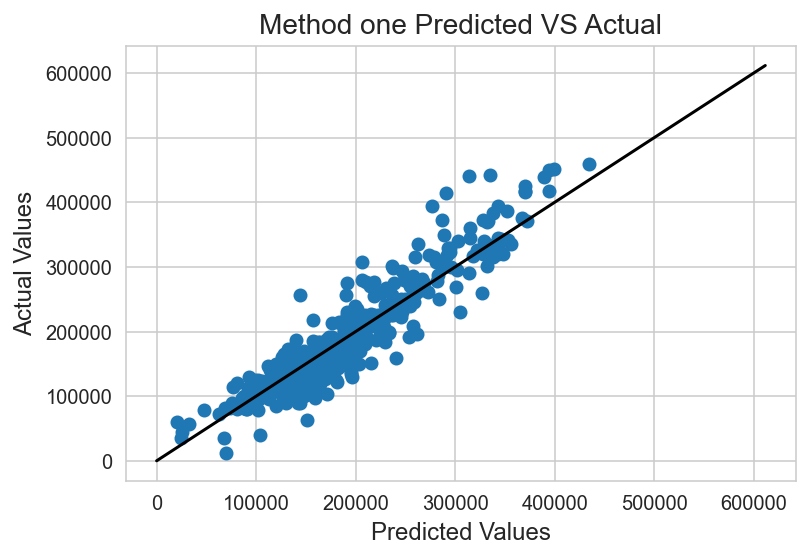

In [29]:
#plot graph for Test set for Predicted value vs actual value
plt.scatter(prediction,y_test)
#plot the ideal fit line
plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k')
#set the Xlabel
plt.xlabel("Predicted Values",fontsize=12)
#set the y label
plt.ylabel("Actual Values",fontsize=12)
#set the title
plt.title("Method one Predicted VS Actual",fontsize=14)

In [30]:
mean_squared_error(y_test,prediction)

843694734.2313356

In [31]:
residual=y_test-prediction

Text(0.5, 1.0, 'Method one Residual Histogram')

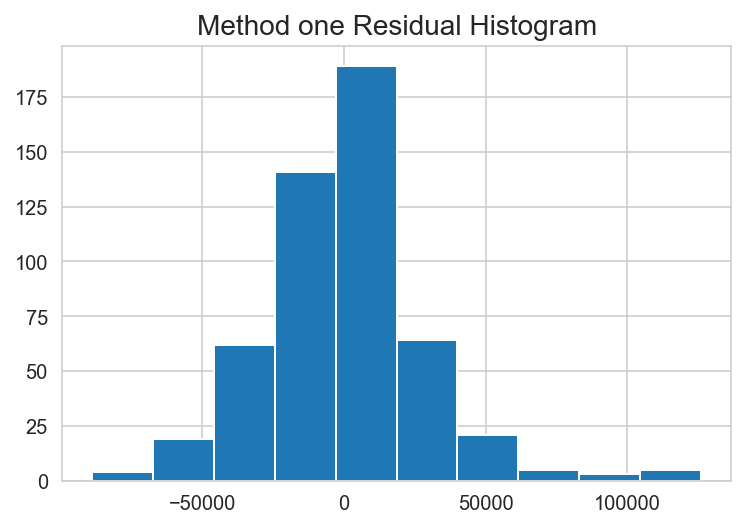

In [32]:
residual.hist()
plt.title("Method one Residual Histogram",fontsize=14)

#### 3.  Parameters Tuning

##### To solve this problem, I tried to tune some parameters to improve the model performance by adjusting the feature coefficient selection range, removing/adding/combining different features containing multi-collinear, train/test split ratio, and alpha value lasso.  However, the High variance in this model still existed.

## Kaggle_Submissions

#### 1. Load the Clean testdata set

In [33]:
#read the csv file from relative path
testdata=pd.read_csv(r'C:\Users\User\materials\project_2\datasets\testdata_clean.csv')

#### 2. Split the columns to numberic and catagorical columns

In [34]:
#get an list contain all numberic columns
test_numberic_column=testdata._get_numeric_data().columns
#get an list of all columns name
test_columns=testdata.columns

In [35]:
#write an loop to get a list of catergory columns
test_category_columns=[]
for x in test_columns:
    if x not in test_numberic_column:
        test_category_columns.append(x)

#### 2. One-hot encoded categorical variables

In [36]:
#convert the categorical variable to one-hot encoded
testdata=testdata[test_numberic_column].join(pd.get_dummies(testdata[test_category_columns]),how="outer")

#### 3. Create our features matrix X and target vectory

In [37]:
#creat the matrix X
testdata=testdata[features]

#### 4.Scaling

In [38]:
ss = StandardScaler()
#fit standardScaler to testdata
ss.fit(testdata)
#transform the data for testdata
testdata = ss.transform(testdata)

#### 5. Predict the sales price in test data set

In [39]:
#predict the value
submission_prediction =lasso.predict(testdata)

#### 7. Adjust to the suitable format for submission

In [40]:
#creat dataframe
submission_prediction=pd.DataFrame(submission_prediction)

In [41]:
#read the csv file from relative path
testdata1=pd.read_csv(r'C:\Users\User\materials\project_2\datasets\test.csv')

In [42]:
#set the ID
submission_prediction["Id"]=testdata1["Id"]

In [43]:
#rename the column
submission_prediction=submission_prediction.rename(columns={0:"SalePrice"})

In [44]:
#sort according to "Id"
submission_prediction=submission_prediction.sort_values(by='Id', ascending=True)

In [45]:
#save the prediction result
submission_prediction.to_csv(r'C:\Users\User\materials\project_2\datasets\submission_prediction_1.csv', index=False)